# Landmark on Graphs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import math

def alignNormalizedPoints(control : list, test: list):
    #index 152 is the bottom of the chin
    #index 10 is top of face
    #index 1 is tip of nose
    #index 168, 6 is middle of eyes
    #etc.
    #pointsOfAlignment = [10, 151, 9, 8, 168, 6, 197, 195, 5, 4, 1, 19, 94, 2, 152]
    #tearducts- 133, 362
    #pointsOfAlignment = [133, 362]

    #top of forehead, bottom of chin - 10, 152
    pointsOfAlignment = [10, 152]
    numPoints = len(pointsOfAlignment)
    delta = 0
    for poa in pointsOfAlignment:
        delta += control[poa] - test[poa]

    delta /= numPoints

    for i in range(len(test)):
        test[i] += delta

    #return control, yCon, test, yTest
    return test

def scalePoints(xCon: list, yCon: list, xTest: list, yTest: list, zCon: list, zTest: list):

    controlDistBetweenEyes = xCon[243] - xCon[362]
    testDistBetweenEyes = xTest[243] - xTest[362]

    scale = controlDistBetweenEyes / testDistBetweenEyes

    scaledXTest = list(map(lambda x: x * scale, xTest))
    scaledYTest = list(map(lambda y: y * scale, yTest))
    scaledZTest = list(map(lambda z: z * scale, zTest))
    
    return scaledXTest, scaledYTest, scaledZTest

def alignNormalizedPointsFixed(xIn : list, yIn: list):
    nostipX = xIn[1]
    nosetipY = yIn[1]

    targetX = .5
    targetY = .5

    deltaX = targetX - nostipX
    deltaY = targetY - nosetipY

    xShift = []
    yShift = []

    for x, y in zip(xIn, yIn):
        xShift.append(x + deltaX)
        yShift.append(y + deltaY) 

    return xShift, yShift


def scalePointsFixed(xIn: list, yIn: list, zIn: list):

    #controlDistBetweenEyes = xCon[243] - xCon[362]
    #hard coding control distance to scale all image to coming from 'same face'
    controlDistBetweenEyes = .05
    testDistBetweenEyes = xIn[243] - xIn[362]

    scale = controlDistBetweenEyes / testDistBetweenEyes

    xOut = list(map(lambda x: x * scale, xIn))
    yOut = list(map(lambda y: y * scale, yIn))
    zOut = list(map(lambda z: z * scale, zIn))
    
    return xOut, yOut, zOut

def flipPoints(input: list):
    flippedPoints = [-p for p in input]
    return flippedPoints

def reversePoints(input: list):
    reveredPoints = [1-p for p in input]
    return reveredPoints

def rotate90CC(affine: np.array):
    rotateMatrix = np.array([[0, 1],
                             [-1, 0]])
    return np.dot(affine, rotateMatrix)

def affineTransform(X: list, Y: list):
    #https://stackoverflow.com/questions/74493141/align-x-and-y-coordinates-of-face-landmarks-in-r
    #133 is left eye tearduct, 362 is right
    #deltaX = X[133] - X[362]
    #deltaY = Y[133] - Y[362]

    #10 is top of forehead, 152 is bottom of chin
    deltaX = X[10] - X[152]
    deltaY = Y[10] - Y[152]
    theta = math.atan2(-deltaY, deltaX)

    rotationMatrix = np.array([[math.cos(theta), -math.sin(theta)],
                              [math.sin(theta), math.cos(theta)]])
    
    rotX = []
    rotY = []

    for x, y in zip(X, Y):
        rotateCoord = np.dot(rotationMatrix, np.array([x, y]))
        rotX.append(rotateCoord[0]) 
        rotY.append(rotateCoord[1])
    
    rotMatrix = np.column_stack((rotX, rotY))

    rotPoints = rotate90CC(rotMatrix)
    rotX = rotPoints[:, 0].tolist()
    rotY = rotPoints[:,1].tolist()

    #rotX = reversePoints(rotX)

    return rotX, rotY


def processImage(xIn: list, yIn: list, zIn: list):
    xOut, yOut = affineTransform(xIn, yIn)
    xOut, yOut, zOut = scalePointsFixed(xOut, yOut, zIn)
    xOut, yOut = alignNormalizedPointsFixed(xOut, yOut)
    return xOut, yOut, zOut

In [2]:


# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
control = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Neutral.jpg')
test = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Smile.jpg')

# STEP 4: Detect face landmarks from the input image.
control_result = detector.detect(control)
test_result = detector.detect(test)



c:\Users\myfir\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [3]:
#https://github.com/tensorflow/tfjs-models/blob/646992fd7ab8237c0dc908f2526301414b417c95/face-landmarks-detection/mesh_map.jpg

assert len(control_result.face_landmarks) == 1 , 'Not exactly one face detected in control image'
assert len(test_result.face_landmarks) == 1, 'Not exactly one face detected in test image'



xControl = [landmark.x for landmark in control_result.face_landmarks[0]]
yControl = [landmark.y for landmark in control_result.face_landmarks[0]]
zControl = [landmark.z for landmark in control_result.face_landmarks[0]]

xTest = [landmark.x for landmark in test_result.face_landmarks[0]]
yTest = [landmark.y for landmark in test_result.face_landmarks[0]]
zTest = [landmark.z for landmark in test_result.face_landmarks[0]]



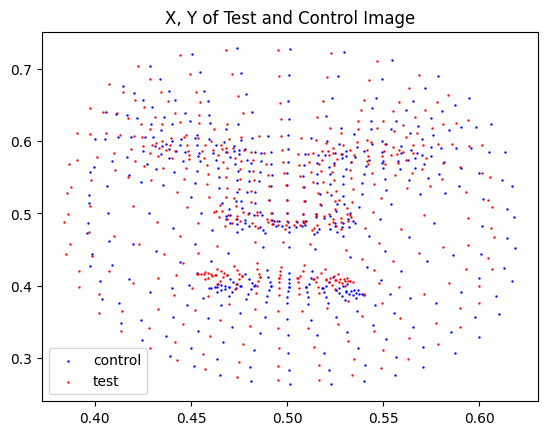

In [4]:
"""
xControl, yControl = affineTransform(xControl, yControl)
xTest, yTest = affineTransform(xTest, yTest)

xTest, yTest, zTest = scalePoints(xControl, yControl, xTest, yTest, zControl, zTest)

xTest = alignNormalizedPoints(xControl, xTest)
yTest = alignNormalizedPoints(yControl, yTest)
zTest = alignNormalizedPoints(zControl, zTest)

yControl = reversePoints(flipPoints(yControl))
yTest = reversePoints(flipPoints(yTest))
xControl = reversePoints(flipPoints(xControl))
xTest = reversePoints(flipPoints(xTest))

#zControl = flipPoints(zControl)
#zTest = flipPoints(zTest)

fig = plt.figure()
plt.scatter(xControl, yControl, label = 'control', color = 'blue', s = .5)
plt.scatter(xTest, yTest, label = 'test', color = 'red', s = .5)
plt.title('X, Y of Test and Control Image')
plt.legend()
plt.show()

"""

xControl, yControl = affineTransform(xControl, yControl)
xTest, yTest = affineTransform(xTest, yTest)

xControl, yControl, zControl = scalePointsFixed(xControl, yControl, zControl)
xTest, yTest, zTest = scalePointsFixed(xTest, yTest, zTest)

xControl, yControl = alignNormalizedPointsFixed(xControl, yControl)
xTest, yTest = alignNormalizedPointsFixed(xTest, yTest)

fig = plt.figure()
plt.scatter(xControl, yControl, label = 'control', color = 'blue', s = .5)
plt.scatter(xTest, yTest, label = 'test', color = 'red', s = .5)
plt.title('X, Y of Test and Control Image')
plt.legend()
plt.show()

In [5]:
# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xControl, yControl, zControl, c='b', marker='o', s= .5, label = 'Control')
ax.scatter(xTest, yTest, zTest, c='r', marker='o', s= .5, label = 'Test')
# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Face')
ax.legend()

# Display the plot
%matplotlib ipympl
#%matplotlib notebook
plt.show()

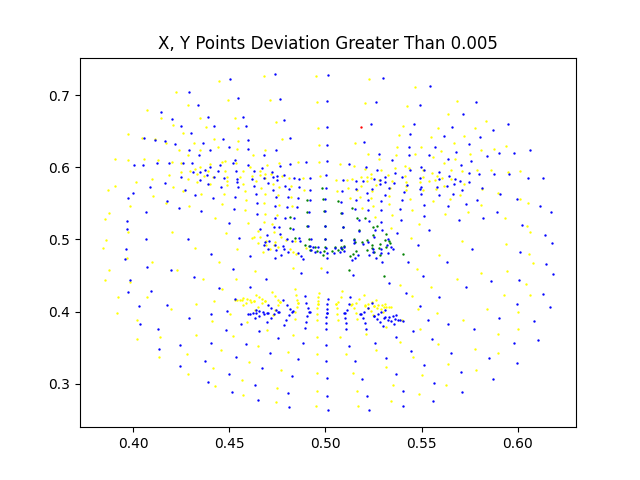

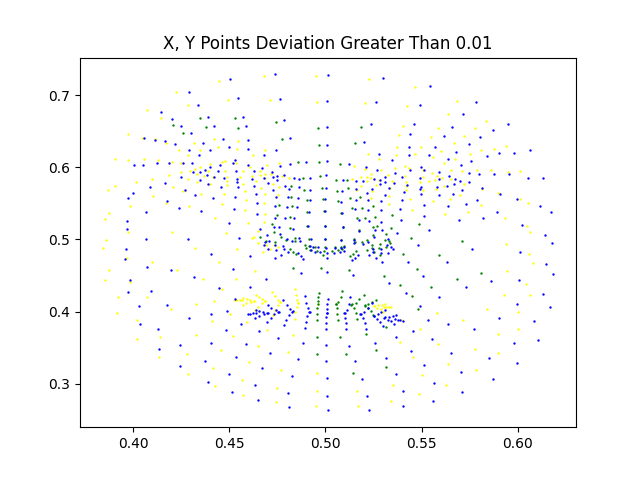

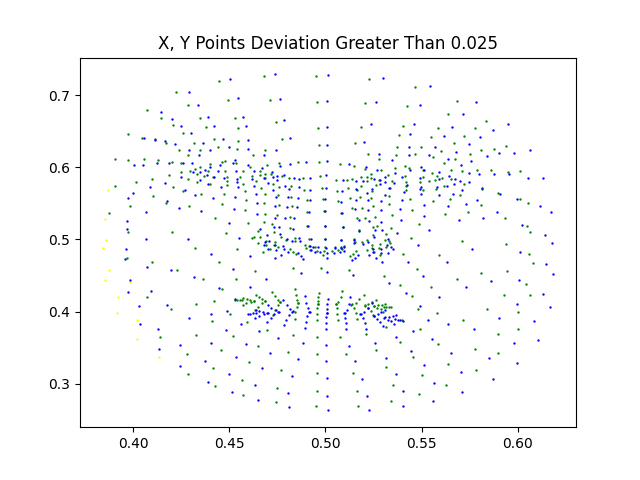

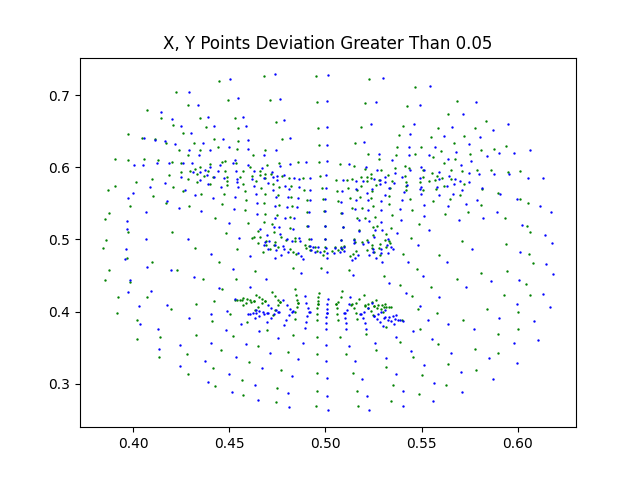

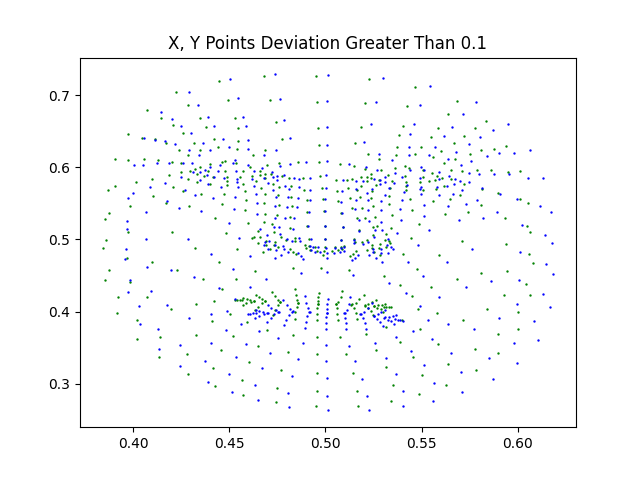

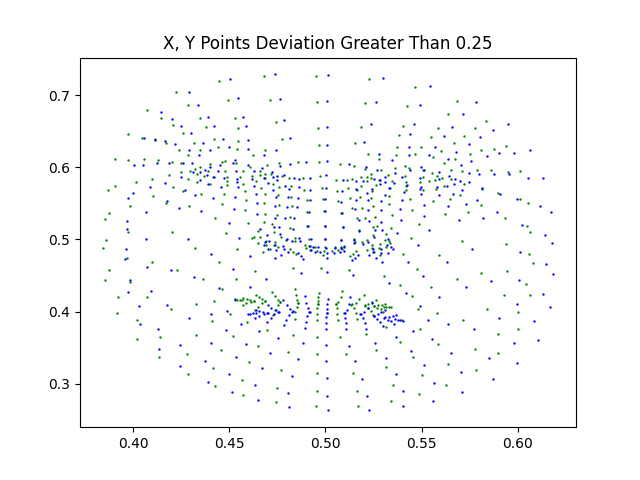

In [6]:
#plt.figure()

percents = [.005, .01, .025, .05, .1, .25]



for p in percents:
    plt.figure()
    handles = []
    labels = []
    xBounds = [[xc - xc*p, xc + xc+p] for xc in xControl]
    yBounds = [[yc - yc*p, yc + yc+p] for yc in yControl]

    for i, (xt, yt, [xl, xu], [yl, yu]) in enumerate(zip(xTest, yTest, xBounds, yBounds)):
        if (xt < xl or xt > xu) and (yt < yl or yt > yu):
            label = f'X, Y dev > {p}'
            color = 'red'
        elif (xt < xl or xt > xu) :
            label = f'X dev > {p}'
            color = 'yellow'
        elif (yt < yl or yt > yu):
            label = f'Y dev > {p}'
            color = 'orange'
        else:
            label = 'No dev'
            color = 'green'
        handles.append(plt.scatter(xTest[i], yTest[i], color=color, s=.5))
        labels.append(label)
    control_handle = plt.scatter(xControl, yControl, color = 'blue', label = 'Control', s = .5)

    #plt.legend()
    plt.title(f'X, Y Points Deviation Greater Than {p}')
    plt.show()


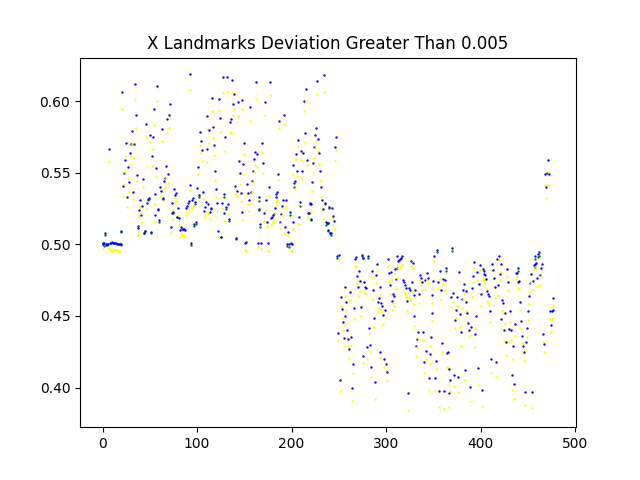

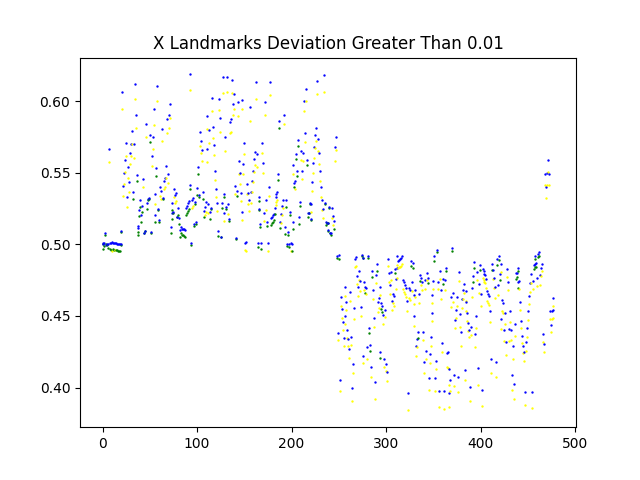

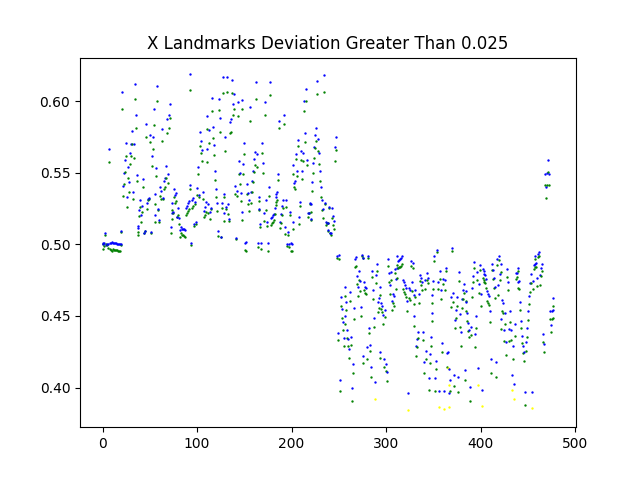

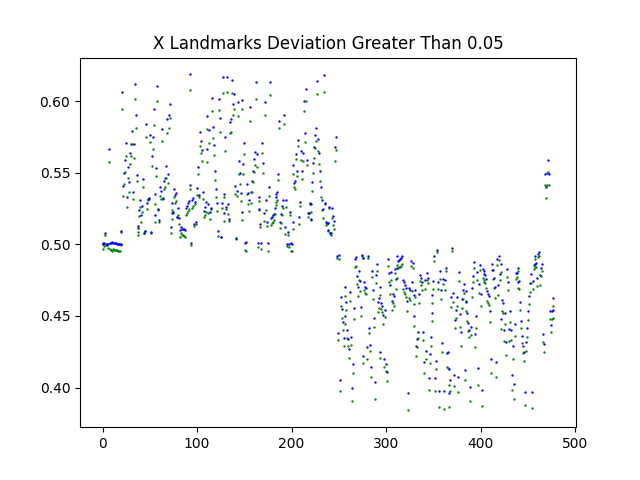

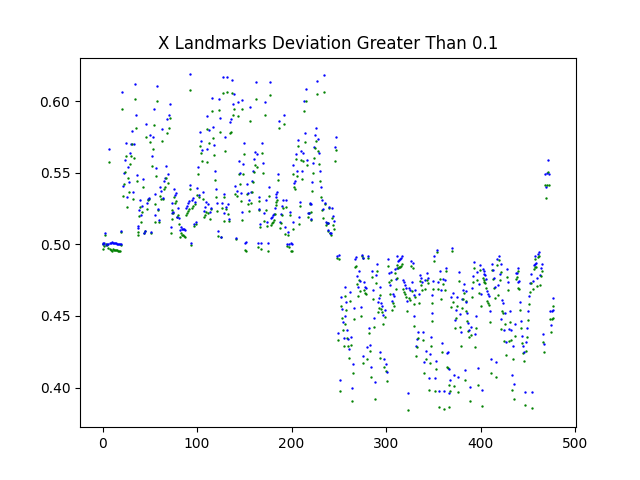

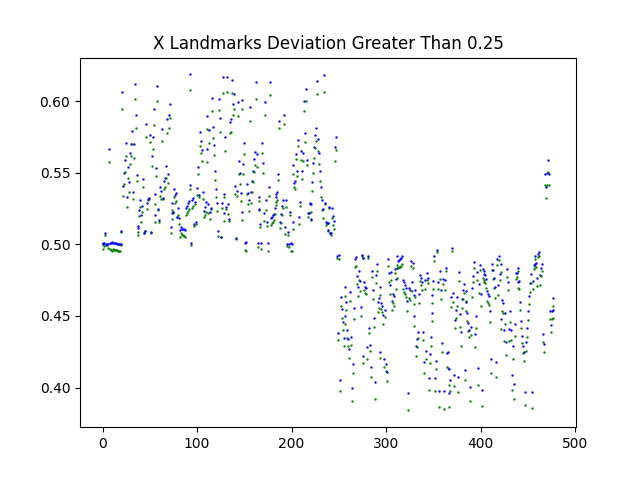

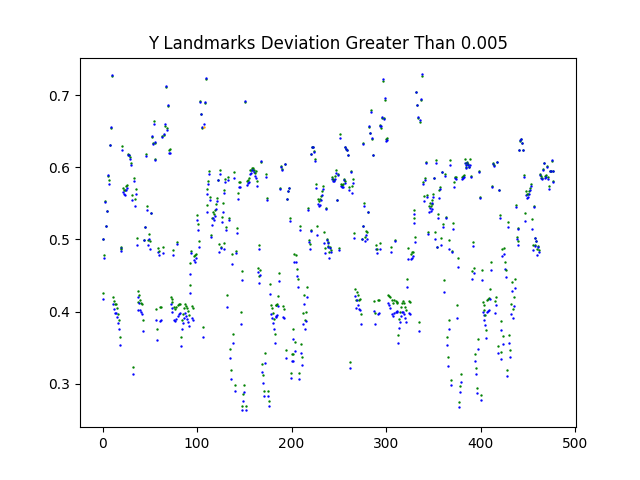

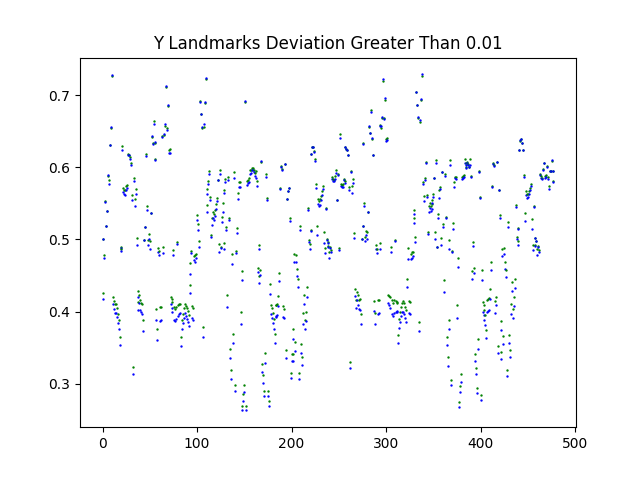

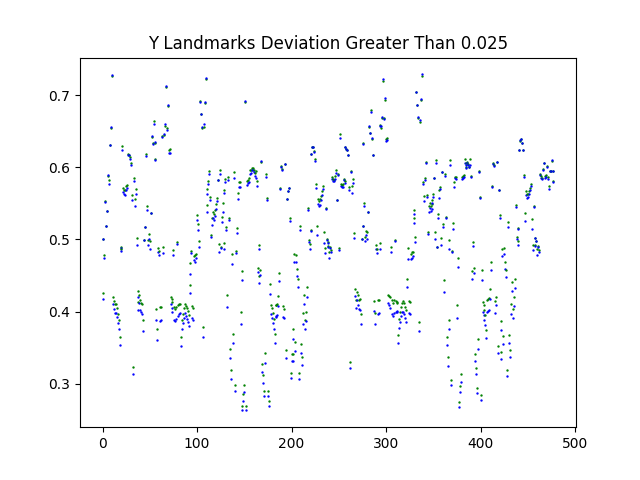

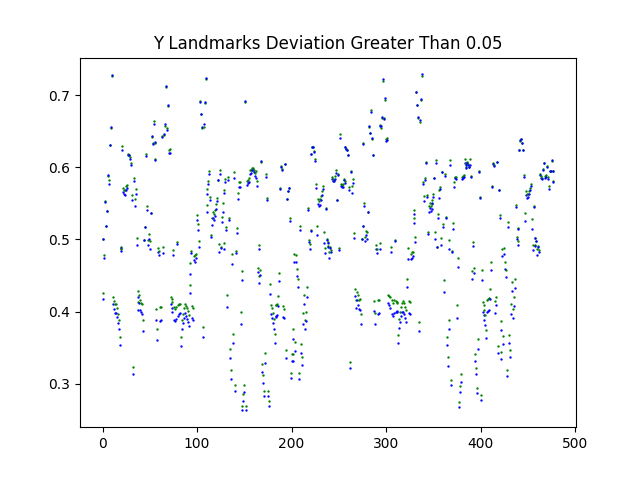

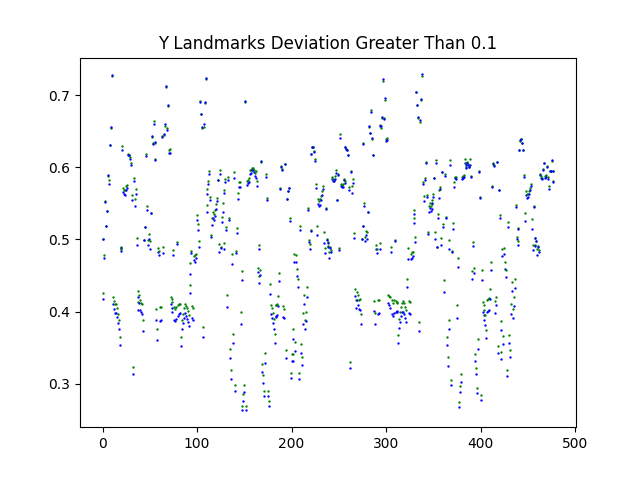

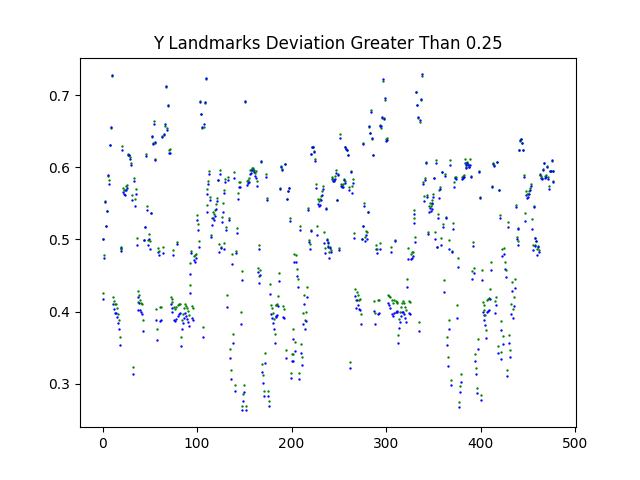

In [7]:
percents = [.005, .01, .025, .05, .1, .25]



for p in percents:
    plt.figure()
    handles = []
    labels = []
    xBounds = [[xc - xc*p, xc + xc+p] for xc in xControl]
    yBounds = [[yc - yc*p, yc + yc+p] for yc in yControl]

    for i, (xt, yt, [xl, xu], [yl, yu]) in enumerate(zip(xTest, yTest, xBounds, yBounds)):
        if (xt < xl or xt > xu) :
            label = f'X dev > {p}'
            color = 'yellow'
        else:
            label = 'No dev'
            color = 'green'
        handles.append(plt.scatter(i, xTest[i], color=color, s=.5))
        labels.append(label)
        control_handle = plt.scatter(i, xControl[i], color = 'blue', label = 'Control', s = .5)

    #plt.legend()
    plt.title(f'X Landmarks Deviation Greater Than {p}')
    plt.show()

    percents = [.005, .01, .025, .05, .1, .25]



for p in percents:
    plt.figure()
    handles = []
    labels = []
    xBounds = [[xc - xc*p, xc + xc+p] for xc in xControl]
    yBounds = [[yc - yc*p, yc + yc+p] for yc in yControl]

    for i, (xt, yt, [xl, xu], [yl, yu]) in enumerate(zip(xTest, yTest, xBounds, yBounds)):
        if (yt < yl or yt > yu):
            label = f'Y dev > {p}'
            color = 'orange'
        else:
            label = 'No dev'
            color = 'green'
        handles.append(plt.scatter(i, yTest[i], color=color, s=.5))
        labels.append(label)
        control_handle = plt.scatter(i, yControl[i], color = 'blue', label = 'Control', s = .5)

    #plt.legend()
    plt.title(f'Y Landmarks Deviation Greater Than {p}')
    plt.show()

# Emotion Reading from Image (frame)

In [13]:
#worth looking in to: ML model for facial recognition -https://www.kaggle.com/code/pabasar/facial-expression-recognition-mediapipe/notebook 
# probably 'better' than Euclidean distance if less explicable
# guidlines for smile thresholds: https://towardsdatascience.com/basic-smile-detection-using-opencv-and-dlib-aeb22afb9e67

from statistics import mean 

def createCentroid(xIn: list, yIn: list):
    avgX = mean(xIn)
    avgY = mean(yIn)
    return (avgX, avgY)

def checkSmile(xIn: list, threshold = .36):
    #cheek points of interest
    #11, 117, 118, 123, 50, 101
    #340, 346, 347, 352, 280, 330

    lipWidth = abs(xIn[61] - xIn[291])
    jawWidth = abs(xIn[93] - xIn[323])
    ratio = lipWidth/jawWidth

    if ratio > threshold:
        return 'smile'
    else:
        return 'no smile'
    


In [15]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
smile = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Smile.jpg')
neutral = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Neutral.jpg')
neutral = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Close up Neutral.jpg')


# STEP 4: Detect face landmarks from the input image.
smile_result = detector.detect(smile)
neutral_result = detector.detect(neutral)

assert len(smile_result.face_landmarks) == 1 , 'Not exactly one face detected in control image'
assert len(neutral_result.face_landmarks) == 1, 'Not exactly one face detected in test image'



xSmile = [landmark.x for landmark in smile_result.face_landmarks[0]]
ySmile = [landmark.y for landmark in smile_result.face_landmarks[0]]
zSmile = [landmark.z for landmark in smile_result.face_landmarks[0]]

xNeutral = [landmark.x for landmark in neutral_result.face_landmarks[0]]
yNeutral = [landmark.y for landmark in neutral_result.face_landmarks[0]]
zNeutral = [landmark.z for landmark in neutral_result.face_landmarks[0]]

print(f'Smile Result: {checkSmile(xSmile)}')
print(f'Neutral Result: {checkSmile(xNeutral)}')

Smile Result: smile


# Graph from Video

In [39]:
import mediapipe as mp
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math

def processFrame(xIn: list, yIn: list, zIn: list, frame: int, timeStamp):
    xOut, yOut = affineTransform(xIn, yIn)

    xOut, yOut, zOut = scalePointsFixed(xOut, yOut, zIn)

    xOut, yOut = alignNormalizedPointsFixed(xOut, yOut)

    fig = plt.figure()
    plt.scatter(xOut, yOut, color = 'blue', s = .5)
    plt.title(f'X, Y of Frame : {frame} | {timeStamp}')
    return xOut, yOut, zOut, fig

def create2DFaceArray(xIn: list, yIn: list):
    #assert len(xIn) == 478 and len(yIn) == 478
    face2D = []
    # 1 tip of nose
    # 33, 263 - right and left tips of eyes
    # 199 near bottom of chin
    # 61, 291 - right and left lip crease
    #face must be six points long for matrix multiplication 

    pois = [1, 199, 33, 263, 61, 291]
    for poi in pois:
        face2D.append([xIn[poi], yIn[poi]])
    face2D = np.array(face2D, dtype = np.float64)
    return face2D

def create3DFaceArray(xIn: list, yIn: list, zIn: list):
    #assert len(xIn) == 478 and len(yIn) == 478 and len(zIn) == 478
    face3D = []
    # 1 tip of nose
    # 33, 263 - right and left tips of eyes
    # 199 near bottom of chin
    # 61, 291 - right and left lip crease

    pois = [1, 199, 33, 263, 61, 291]
    for poi in pois:
        face3D.append([xIn[poi], yIn[poi], zIn[poi]])
    face3D = np.array(face3D, dtype = np.float64)
    return face3D

def createModel3DFaceArray():
    modelFace = np.array([
    (0.0, 0.0, 0.0),  # Nose tip
    (0.0, -330.0, -65.0),  # Chin
    (-225.0, 170.0, -135.0),  # Left eye left corner
    (225.0, 170.0, -135.0),  # Right eye right corner
    (-150.0, -150.0, -125.0),  # Left mouth corner
    (150.0, -150.0, -125.0)   # Right mouth corner
    ])
    return modelFace

def createCamMatrix(imageWidth: int, imageHeight: int):
    focalLength = 1 * imageHeight
    #height, width = im.shape[0], im.shape[1]
    camMatrix = np.array([[focalLength, 0 , imageWidth/2], 
                          [0, focalLength, imageHeight/2],
                          [0, 0, 1]])
    return camMatrix

def scaleLandmarksToImage(xIn: list, yIn: list, zIn: list, imageWidth: int, imageHeight: int):
    xOut = [x * imageWidth for x in xIn]
    yOut = [y * imageHeight for y in yIn]
    zOut = [z * imageWidth for z in zIn]
    return xOut, yOut, zOut

def PnPSolution(xIn: list, yIn: list, zIn: list, imageWidth: int, imageHeight: int):
    #https://github.com/niconielsen32/ComputerVision/blob/master/headPoseEstimation.py
    face2d = create2DFaceArray(xIn, yIn)
    #face3d = create3DFaceArray(xIn, yIn, zIn)
    face3d = createModel3DFaceArray()
    distMatrix = np.zeros((4, 1), dtype=np.float64)
    camMatrix = createCamMatrix(imageWidth, imageHeight)

    success, rotVector, translationVector = cv2.solvePnP(face3d, face2d, camMatrix, distMatrix)
    return success, rotVector, translationVector

def createEulerAngles(rotVector):
    #thanks, ChatGPT
    rotation_matrix, _ = cv2.Rodrigues(rotVector)
    sy = math.sqrt(rotation_matrix[0, 0] * rotation_matrix[0, 0] + rotation_matrix[1, 0] * rotation_matrix[1, 0])
    singular = sy < 1e-6
    if not singular:
        x = math.atan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
        y = math.atan2(-rotation_matrix[2, 0], sy)
        z = math.atan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    else:
        x = math.atan2(-rotation_matrix[1, 2], rotation_matrix[1, 1])
        y = math.atan2(-rotation_matrix[2, 0], sy)
        z = 0
    return np.array([x, y, z])

def createRotMatFromEuler(eulerAngles):
    pitch, yaw, roll = eulerAngles
    
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(pitch), -math.sin(pitch)],
        [0, math.sin(pitch), math.cos(pitch)]
    ])
    
    Ry = np.array([
        [math.cos(yaw), 0, math.sin(yaw)],
        [0, 1, 0],
        [-math.sin(yaw), 0, math.cos(yaw)]
    ])
    
    Rz = np.array([
        [math.cos(roll), -math.sin(roll), 0],
        [math.sin(roll), math.cos(roll), 0],
        [0, 0, 1]
    ])
    
    R = Rz @ Ry @ Rx
    return R

def create_transformation_matrix(pitch, yaw, roll):
    # Create rotation matrices for each axis
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(pitch), -np.sin(pitch)],
                   [0, np.sin(pitch), np.cos(pitch)]])
    
    Ry = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                   [0, 1, 0],
                   [-np.sin(yaw), 0, np.cos(yaw)]])
    
    Rz = np.array([[np.cos(roll), -np.sin(roll), 0],
                   [np.sin(roll), np.cos(roll), 0],
                   [0, 0, 1]])
    
    # Combine rotations
    R = np.dot(Rz, np.dot(Ry, Rx))
    return R

def transformed3DPoints(xIn: list, yIn: list, zIn: list, imageWidth: int, imageHeight: int, rotationVector, translationVector):
    euler = createEulerAngles(rotationVector)
    rotationMatrix = createRotMatFromEuler(euler)
    #xIn, yIn, zIn = scaleLandmarksToImage(xIn, yIn, zIn, imageWidth, imageHeight)
    landmarks3D = np.column_stack((xIn, yIn, zIn))
    camMatrix = createCamMatrix(imageWidth, imageHeight)
    distMatrix = np.zeros((4, 1), dtype=np.float64)

    #rotation_matrix, _ = cv2.Rodrigues(rotationVector)
    inverse_rot_matrix = np.linalg.inv(rotationMatrix)
    #transformed3DLandmarks = (inverse_rot_matrix @ landmarks3D.T).T + translationVector.T
    #transformed3DLandmarks = (inverse_rot_matrix @ (landmarks3D - translationVector.T).T).T
    transformed3DLandmarks = (inverse_rot_matrix @ (landmarks3D.T - translationVector)).T

    projected2DPoints, _ = cv2.projectPoints(transformed3DLandmarks,
                                             np.zeros((3, 1)),  # No additional rotation
                                             np.zeros((3, 1)),  # No additional translation
                                             camMatrix,
                                             distMatrix
                                            )
    
    return projected2DPoints.reshape(-1, 2)

def transformed3DPointsTest(xIn: list, yIn: list, zIn: list, rotationVector, translationVector):
    rvec_matrix, _ = cv2.Rodrigues(rotationVector)
    proj_matrix = np.hstack((rvec_matrix, translationVector))
    euler_angles = cv2.decomposeProjectionMatrix(proj_matrix)[6]

    pitch, yaw, roll = [math.degrees(math.asin(math.sin(angle))) for angle in euler_angles]
    R = create_transformation_matrix(pitch, yaw, roll)
    RInv = np.linalg.inv(R)
    transformed3DLandmarks = []
    for x, y, z in zip(xIn, yIn, zIn):
        points = np.array([x, y, z])
        
        frontPoint = np.dot(RInv, points).tolist()
        transformed3DLandmarks.append(frontPoint)
    

    return np.array(transformed3DLandmarks)
    #return projected2DPoints.reshape(-1, 2)


In [40]:
#facemesh

videoPath = r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Video 2.mp4'
video = cv2.VideoCapture(videoPath)
fps = video.get(cv2.CAP_PROP_FPS)
frameWidth = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
currentFrame = 0

iteration = 12
directory = f'plots_{iteration}'

# Get the parent directory of videoPath
parentDir = os.path.dirname(videoPath)

# Create the directory for plots
plotsDir = os.path.join(parentDir, directory)

os.makedirs(plotsDir, exist_ok=True)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        currentFrame += 1
        
        timestamp_ms = int(video.get(cv2.CAP_PROP_POS_MSEC) * 1000)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)
        
        if len(results.multi_face_landmarks) == 1:
            xs = [landmark.x for landmark in results.multi_face_landmarks[0].landmark]
            ys = [landmark.y for landmark in results.multi_face_landmarks[0].landmark]
            zs = [landmark.z for landmark in results.multi_face_landmarks[0].landmark]

            
            xs , ys, zs, fig = processFrame(xs, ys, zs, currentFrame, timestamp_ms)
            fig.savefig(f'{plotsDir}/frame_{currentFrame}.png')
            plt.close(fig)
            plt.clf()

            xs = [landmark.x for landmark in results.multi_face_landmarks[0].landmark]
            ys = [landmark.y for landmark in results.multi_face_landmarks[0].landmark]
            zs = [landmark.z for landmark in results.multi_face_landmarks[0].landmark]
            xs, ys, zs = scaleLandmarksToImage(xs, ys, zs, frameWidth, frameHeight)
            success, rotVector, translationVector = PnPSolution(xs, ys, zs, frameWidth, frameHeight)
            proj = transformed3DPointsTest(xs, ys, zs, rotVector, translationVector)

            projXs = proj[:,0].tolist()
            projYs = proj[:,1].tolist()

            xs , ys, zs, fig = processFrame(projXs, projYs, zs, currentFrame, timestamp_ms)
            fig.savefig(f'{plotsDir}/frame_proj_{currentFrame}.png')
            plt.close(fig)
            plt.clf()
        del image



c:\Users\myfir\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\myfir\AppData\Local\Temp\ipykernel_24708\2475782816.py:170: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pitch, yaw, roll = [math.degrees(math.asin(math.sin(angle))) for angle in euler_angles]


<Figure size 640x480 with 0 Axes>

In [28]:
results.multi_face_landmarks[0].landmark


[x: 0.528386414
y: 0.479001284
z: -0.0685097426
, x: 0.524043739
y: 0.431387901
z: -0.100157894
, x: 0.527179837
y: 0.448019832
z: -0.0593253151
, x: 0.506865799
y: 0.3967655
z: -0.063591
, x: 0.523249507
y: 0.419323653
z: -0.103507921
, x: 0.523257196
y: 0.405174285
z: -0.091709964
, x: 0.52395469
y: 0.372916967
z: -0.0281737894
, x: 0.392549723
y: 0.383543968
z: 0.04811294
, x: 0.523321688
y: 0.344849557
z: -0.00585229183
, x: 0.522800505
y: 0.329426
z: -0.00338928984
, x: 0.523985267
y: 0.287875473
z: 0.0374214053
, x: 0.528703511
y: 0.484939724
z: -0.0669294372
, x: 0.529169917
y: 0.489844143
z: -0.0613616742
, x: 0.5295
y: 0.492344
z: -0.0539451689
, x: 0.529175758
y: 0.494810581
z: -0.0544181
, x: 0.528894126
y: 0.498883694
z: -0.0591489
, x: 0.528831303
y: 0.504613936
z: -0.065838404
, x: 0.528995752
y: 0.511225581
z: -0.0668614656
, x: 0.530215263
y: 0.524677575
z: -0.0555043593
, x: 0.52509886
y: 0.438587308
z: -0.092103526
, x: 0.507959723
y: 0.440411359
z: -0.0673103258
, x:

In [38]:


videoPath = r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Video 2.mp4'
video = cv2.VideoCapture(videoPath)
fps = video.get(cv2.CAP_PROP_FPS)
frameWidth = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
currentFrame = 0

iteration = 13
directory = f'plots_{iteration}'

# Get the parent directory of videoPath
parentDir = os.path.dirname(videoPath)

# Create the directory for plots
plotsDir = os.path.join(parentDir, directory)

os.makedirs(plotsDir, exist_ok=True)

BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face landmarker instance with the video mode:
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='face_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO)

with FaceLandmarker.create_from_options(options) as landmarker:
  # The landmarker is initialized. Use it here.
  # ...
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        currentFrame += 1
        
        timestamp_ms = int(video.get(cv2.CAP_PROP_POS_MSEC) * 1000)
        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        results = landmarker.detect_for_video(image, timestamp_ms)
        
        if len(results.face_landmarks) == 1:
            xs = [landmark.x for landmark in results.face_landmarks[0]]
            ys = [landmark.y for landmark in results.face_landmarks[0]]
            zs = [landmark.z for landmark in results.face_landmarks[0]]

            
            xs , ys, zs, fig = processFrame(xs, ys, zs, currentFrame, timestamp_ms)
            fig.savefig(f'{plotsDir}/frame_{currentFrame}.png')
            plt.close(fig)
            plt.clf()

            xs = [landmark.x for landmark in results.face_landmarks[0]]
            ys = [landmark.y for landmark in results.face_landmarks[0]]
            zs = [landmark.z for landmark in results.face_landmarks[0]]
            success, rotVector, translationVector = PnPSolution(xs, ys, zs, frameWidth, frameHeight)
            proj = transformed3DPointsTest(xs, ys, zs, rotVector, translationVector)

            projXs = proj[:,0].tolist()
            projYs = proj[:,1].tolist()

            xs , ys, zs, fig = processFrame(projXs, projYs, zs, currentFrame, timestamp_ms)
            fig.savefig(f'{plotsDir}/frame_proj_{currentFrame}.png')
            plt.close(fig)
            plt.clf()
        del image







RuntimeError: Unable to open file at c:\Users\myfir\AppData\Local\Programs\Python\Python311\Lib\site-packages/c:\Users\myfir\Code and Repos\VisionScratch\Mediapipe\face_landmarker.task, errno=22

In [4]:
import os
import cv2
import numpy as np
import subprocess

# Input video path and graph images directory
graphs_dir = plotsDir

# Output video path
output_video_path = rf'{plotsDir}/stitchVid.mp4'

# Open the input video file
video = cv2.VideoCapture(videoPath)
fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

#640x480
# Prepare output video writer with new dimensions
graph_height = frame_height  # Assuming graphs have the same height as video frames
new_frame_width = frame_width * 2  # Double width for video frame + graph image
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (new_frame_width, frame_height))

# Iterate through frames
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
for i in range(frame_count):
    ret, frame = video.read()
    if not ret:
        break
    
    # Assuming graph images are named in sequential order (e.g., 00001.png, 00002.png, ...)
    graph_path = os.path.join(graphs_dir, f'frame_{i + 1}.png')  # Adjust filename format as needed
    
    if os.path.exists(graph_path):
        graph = cv2.imread(graph_path)
        # Resize graph image to match video frame height
        graph_resized = cv2.resize(graph, (frame_width, frame_height))
        
        # Concatenate frame and graph image horizontally
        combined_frame = np.concatenate((frame, graph_resized), axis=1)
        
        # Write the combined frame to the output video
        out.write(combined_frame)
    
    else:
        print(f'Graph image {graph_path} does not exist.')

# Release resources
video.release()
out.release()

print(f'Output video saved to {output_video_path}')


Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_234.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_235.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_236.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_237.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_238.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_239.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_240.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_241.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_242.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\

In [5]:
import os
import cv2
import numpy as np
import subprocess

# Input video path and graph images directory
graphs_dir = plotsDir

# Output video path
output_video_path = rf'{plotsDir}/stitchVidProj.mp4'

# Open the input video file
video = cv2.VideoCapture(videoPath)
fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

#640x480
# Prepare output video writer with new dimensions
graph_height = frame_height  # Assuming graphs have the same height as video frames
new_frame_width = frame_width * 2  # Double width for video frame + graph image
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (new_frame_width, frame_height))

# Iterate through frames
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
for i in range(frame_count):
    ret, frame = video.read()
    if not ret:
        break
    
    # Assuming graph images are named in sequential order (e.g., 00001.png, 00002.png, ...)
    graph_path = os.path.join(graphs_dir, f'frame_proj_{i + 1}.png')  # Adjust filename format as needed
    
    if os.path.exists(graph_path):
        graph = cv2.imread(graph_path)
        # Resize graph image to match video frame height
        graph_resized = cv2.resize(graph, (frame_width, frame_height))
        
        # Concatenate frame and graph image horizontally
        combined_frame = np.concatenate((frame, graph_resized), axis=1)
        
        # Write the combined frame to the output video
        out.write(combined_frame)
    
    else:
        print(f'Graph image {graph_path} does not exist.')

# Release resources
video.release()
out.release()

print(f'Output video saved to {output_video_path}')

Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_234.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_235.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_236.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_237.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_238.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_239.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_240.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_241.png does not exist.
Graph image C:\Users\myfir\My Drive\Skyline\Personal Expression\plots_11\frame_proj_242.png does not exist.
Graph image C:\Users\myfir\M